In [246]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [247]:
df_iris = spark.read.csv(
    'iris.csv',
    sep=',',
    header=True,
)
df_iris.printSchema()

root
 |-- sepal.length: string (nullable = true)
 |-- sepal.width: string (nullable = true)
 |-- petal.length: string (nullable = true)
 |-- petal.width: string (nullable = true)
 |-- variety: string (nullable = true)



In [ ]:
# при считывании данных функция spark.read.csv неверно определяет типы данных, поэтому
# зададим явно структуру входных данных с помошью StructField() и StructType()

In [248]:
from pyspark.sql.types import *

df_schema = [
               StructField('sepal.length', DoubleType(), True),
               StructField('sepal.width', DoubleType(), True),
               StructField('petal.length',DoubleType(), True),
               StructField('petal.width', DoubleType(), True),
               StructField('variety', StringType(), True),
            ]
df_format = StructType(fields = df_schema)

df_iris = spark.read.csv(
    'iris.csv',
    sep=',',
    header=True,
    schema = df_format
)
df_iris.printSchema()

root
 |-- sepal.length: double (nullable = true)
 |-- sepal.width: double (nullable = true)
 |-- petal.length: double (nullable = true)
 |-- petal.width: double (nullable = true)
 |-- variety: string (nullable = true)



In [62]:
# выведем названия столбцов датасета

In [249]:
df_iris.columns

['sepal.length', 'sepal.width', 'petal.length', 'petal.width', 'variety']

In [250]:
# Проверим на соответствие созданого датасета ( типы данных) данным в исходном файле
df_iris.head(4)

[Row(sepal.length=5.1, sepal.width=3.5, petal.length=1.4, petal.width=0.2, variety='Setosa'),
 Row(sepal.length=4.9, sepal.width=3.0, petal.length=1.4, petal.width=0.2, variety='Setosa'),
 Row(sepal.length=4.7, sepal.width=3.2, petal.length=1.3, petal.width=0.2, variety='Setosa'),
 Row(sepal.length=4.6, sepal.width=3.1, petal.length=1.5, petal.width=0.2, variety='Setosa')]

In [ ]:
#!!! Использование точки в названии аттрибута ( ex. sepal.length) приводит к ошибке, связанной  
# с использованием в имени знака пунктуации ".". Поэтому переименуем столбцы датасета

In [251]:
df_iris = df_iris.withColumnRenamed("sepal.length", "sepallength")
df_iris = df_iris.withColumnRenamed("sepal.width", "sepalwidth")
df_iris = df_iris.withColumnRenamed("petal.length", "petallength")
df_iris = df_iris.withColumnRenamed("petal.width", "petalwidth")
df_iris.printSchema()

root
 |-- sepallength: double (nullable = true)
 |-- sepalwidth: double (nullable = true)
 |-- petallength: double (nullable = true)
 |-- petalwidth: double (nullable = true)
 |-- variety: string (nullable = true)



In [252]:
df_iris.columns # проверим названия столбцов

['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'variety']

In [ ]:
# Для формулирования гипотезы о зависимости качества прогнозирования модели от параметров
# исходных данных просмотрим на точность прогнозирования при различных вариантах разбиения 
# исходной выборки на train и test
# Если посмотреть на вариант точечной диаграммы распределения параметров (petallength, petalwidth)
# и (sepallength, sepalwidth),
# то видно что имеется область пересечения для цветков versicolor и virginica.
# следовательно на точность модели будет влиять то как будут распределяться наборы параметров из
# области пересечения. Т.е. ошибки модели ожидаются в точности определения цветков
# versicolor и virginica ( их количество с исходных данных и прогнозных могут отличаться)

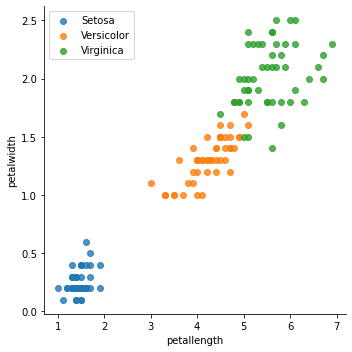

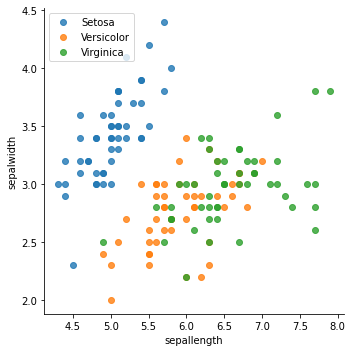

In [253]:

from matplotlib import pyplot as plt
import seaborn as sns

flower = df_iris.select(['petallength', 'petalwidth','variety']).toPandas()
flower2 = df_iris.select(['sepallength', 'sepalwidth','variety']).toPandas()

sns.lmplot( x="petallength", y="petalwidth", data=flower, fit_reg=False, hue='variety', legend=False)
plt.legend(loc='upper left')

sns.lmplot( x="sepallength", y="sepalwidth", data=flower2, fit_reg=False, hue='variety', legend=False)
plt.legend(loc='upper left')

In [342]:
# Для оценки вышеприведенной гипотезы о возможных причинах неточности модели создадим словарь
# result_dict, в который будем заносить результаты работы модели при очередном сгенерированном
# наборе train, test( значения ключей: train - размер выборки train, test - размер выбрки test,
# acc_train - точность модели на наборе train, acc_test - точность модели на наборе test,
# s_test - количество ошибок предсказнаний типа Setosa в наборе test, s_train - 
#  количество ошибок предсказнаний типа Setosa в наборе train, vir_test -  количество ошибок
# предсказнаний типа Virginica в наборе test, vir_train -  количество ошибок предсказнаний типа 
# Virginica в наборе train, ver_test -  количество ошибок предсказнаний типа Versicolor в наборе
# test, ver_train - количество ошибок предсказнаний типа Versicolor в наборе train )
# DataFrame result для сбора данных по всем разбиени на train и test наборы.
# заполняться DataFrame result будет после каждого расчета модели при смене разбиения исх. набора

lst = ['train','test', 'acc_train', 'acc_test', 's_test','s_train', 'vir_test','vir_train', 'ver_test', 'ver_train']
result_dict = dict.fromkeys(lst,0)
result = pd.DataFrame()
result


""


In [ ]:
# Для дальнейщего построения модели с помощью библиотеки Spark, загрузим необходимые методы

In [343]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer 



In [344]:
# Т.к. для построения модели необходимо перевести все данные в числовое представление, то заменим
# строковые значений колонки variety ( это значение и будет предсказываться в построенной модели )
# на числовые.
# Добавлена колонка variety_1 с числовыми значениями для имен Setosa, Versicolor, Virginica

from pyspark.sql.functions import when
df_iris = df_iris.withColumn('variety_1',
            when(df_iris['variety'] == 'Setosa', 1.0).
            when(df_iris['variety'] == 'Virginica', 2.0).
            otherwise(3.0))
print('Измененный датасет:')
df_iris.show(5) 

Измененный датасет:
+-----------+----------+-----------+----------+-------+---------+
|sepallength|sepalwidth|petallength|petalwidth|variety|variety_1|
+-----------+----------+-----------+----------+-------+---------+
|        5.1|       3.5|        1.4|       0.2| Setosa|      1.0|
|        4.9|       3.0|        1.4|       0.2| Setosa|      1.0|
|        4.7|       3.2|        1.3|       0.2| Setosa|      1.0|
|        4.6|       3.1|        1.5|       0.2| Setosa|      1.0|
|        5.0|       3.6|        1.4|       0.2| Setosa|      1.0|
+-----------+----------+-----------+----------+-------+---------+
only showing top 5 rows



In [259]:
# отберем необходимые колонки для дальнейшей обработки датасета
df = df_iris.select(['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'variety_1'])
df.show()

+-----------+----------+-----------+----------+---------+
|sepallength|sepalwidth|petallength|petalwidth|variety_1|
+-----------+----------+-----------+----------+---------+
|        5.1|       3.5|        1.4|       0.2|      1.0|
|        4.9|       3.0|        1.4|       0.2|      1.0|
|        4.7|       3.2|        1.3|       0.2|      1.0|
|        4.6|       3.1|        1.5|       0.2|      1.0|
|        5.0|       3.6|        1.4|       0.2|      1.0|
|        5.4|       3.9|        1.7|       0.4|      1.0|
|        4.6|       3.4|        1.4|       0.3|      1.0|
|        5.0|       3.4|        1.5|       0.2|      1.0|
|        4.4|       2.9|        1.4|       0.2|      1.0|
|        4.9|       3.1|        1.5|       0.1|      1.0|
|        5.4|       3.7|        1.5|       0.2|      1.0|
|        4.8|       3.4|        1.6|       0.2|      1.0|
|        4.8|       3.0|        1.4|       0.1|      1.0|
|        4.3|       3.0|        1.1|       0.1|      1.0|
|        5.8| 

In [447]:
# Разбиваем исходный датасет на тренировочный т тестовый: train и test (70/30, 80/20, 90/10)
(train_df, test_df) = df.randomSplit([0.9, 0.1])
print(f"Размер набора train - {train_df.count()}, размер набора test - {test_df.count()}")
result_dict['test'] = test_df.count()
result_dict['train'] = train_df.count()

Размер набора train - 128, размер набора test - 22


In [448]:
# Построим модель логистической регрессии и обучим ее
# Этап преобразования исходных параметров в векторное представление
stage_1 = VectorAssembler(inputCols=['sepallength', 'sepalwidth', 'petallength', 'petalwidth'],
                          outputCol='features')
# Построение логистической регрессии (исходный вестор данных , результируюший параметр)
stage_2 = LogisticRegression(featuresCol='features',labelCol='variety_1')

# Построение потока вычислений
regression_pipeline = Pipeline(stages = [stage_1, stage_2])
# поcтроение модели на тренировочном наборе данных train
model = regression_pipeline.fit(train_df)
# вычисление модели для набора train
train_df = model.transform(train_df)

# Выбор некоторых данных полученной модели ( variety_1 фактическое значение,
# prediction _ вычисленное значение параметра с помощью построенной модели )
train_df.select('features', 'variety_1', 'rawPrediction', 'probability', 'prediction').show()

+-----------------+---------+--------------------+-----------------+----------+
|         features|variety_1|       rawPrediction|      probability|prediction|
+-----------------+---------+--------------------+-----------------+----------+
|[4.3,3.0,1.1,0.1]|      1.0|[-2001.0212502150...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.4,2.9,1.4,0.2]|      1.0|[-1992.7990941015...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.4,3.0,1.3,0.2]|      1.0|[-2028.7859594843...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.4,3.2,1.3,0.2]|      1.0|[-2105.8215799455...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.5,2.3,1.3,0.3]|      1.0|[-1781.8641074437...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.6,3.1,1.5,0.2]|      1.0|[-2109.0590772433...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.6,3.2,1.4,0.2]|      1.0|[-2145.0459426261...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.6,3.4,1.4,0.3]|      1.0|[-2226.4376737446...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.6,3.6,1.0,0.2]|      1.0|[-2288.9934041572...|[0.0,1.0,0.0,0.0]|       1.0|
|[4.7,3.2,1.3,0.2]|      1.0|[-2160.8617

In [449]:
# оценим точность модели "ручным способом"
df_w = train_df.filter(train_df['variety_1'] == train_df['prediction'])
print(f"количество: {df_w.count()}")
print(f"точность предсказания модели на наборе train в %: {df_w.count()/train_df.count()*100}")

количество: 128
точность предсказания модели на наборе train в %: 100.0


In [450]:
# выведим записи с несоответствием исходного значения и предсказанного на наборе train
df_w_no = train_df.filter(train_df['variety_1'] != train_df['prediction'])
print(f"количество: {df_w_no.count()}")
df_w_no.select(['variety_1','prediction']).show()

количество: 0
+---------+----------+
|variety_1|prediction|
+---------+----------+
+---------+----------+



In [451]:

# применим полученную модель для набора test
test_df = model.transform(test_df)
# Выбор некоторых данных полученной модели ( variety_1 фактическое значение,
# prediction _ вычисленное значение параметра с помощью построенной модели )
test_df.select('features','variety_1', 'rawPrediction', 'probability', 'prediction').show()

+-----------------+---------+--------------------+--------------------+----------+
|         features|variety_1|       rawPrediction|         probability|prediction|
+-----------------+---------+--------------------+--------------------+----------+
|[4.8,3.0,1.4,0.1]|      1.0|[-2100.3476293403...|   [0.0,1.0,0.0,0.0]|       1.0|
|[4.8,3.1,1.6,0.2]|      1.0|[-2148.2834399239...|   [0.0,1.0,0.0,0.0]|       1.0|
|[4.9,2.4,3.3,1.0]|      3.0|[-1974.8804248972...|   [0.0,0.0,0.0,1.0]|       3.0|
|[4.9,2.5,4.5,1.7]|      2.0|[-2074.2623479026...|[0.0,0.0,1.0,4.14...|       2.0|
|[5.0,2.0,3.5,1.0]|      3.0|[-1844.2177825868...|[0.0,0.0,1.856034...|       3.0|
|[5.0,3.5,1.3,0.3]|      1.0|[-2335.8113747929...|   [0.0,1.0,0.0,0.0]|       1.0|
|[5.4,3.7,1.5,0.2]|      1.0|[-2486.9396099580...|   [0.0,1.0,0.0,0.0]|       1.0|
|[5.6,2.7,4.2,1.3]|      3.0|[-2254.7076536059...|[0.0,0.0,3.543888...|       3.0|
|[5.6,2.8,4.9,2.0]|      2.0|[-2341.4348523721...|[0.0,0.0,1.0,4.29...|       2.0|
|[5.

In [452]:
# оценим точность модели на наборе test
df_t = test_df.filter(test_df['variety_1'] == test_df['prediction'])
print(f"точность предсказания модели на наборе test в %: {df_t.count()/test_df.count()*100}")


точность предсказания модели на наборе test в %: 95.45454545454545


In [453]:
# выведим записи с несоответствием исходного значения и предсказанного на наборе test
df_w_no = test_df.filter(test_df['variety_1'] != test_df['prediction'])
print(f"количество: {df_w_no.count()}")
df_w_no.select(['variety_1','prediction']).show()

количество: 1
+---------+----------+
|variety_1|prediction|
+---------+----------+
|      3.0|       2.0|
+---------+----------+



In [ ]:
# Воспользуемся MulticlassClassificationEvaluator для оценки качества на train и test 
# наборах

In [454]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol = 'variety_1')
test_accuracy = evaluator.evaluate(test_df, {evaluator.metricName: "accuracy"})
print(f" качество для набора test: {test_accuracy}  или {test_accuracy*100} в %")
result_dict['acc_test'] = test_accuracy*100


 качество для набора test: 0.9545454545454546  или 95.45454545454545 в %


In [455]:
train_accuracy = evaluator.evaluate(train_df, {evaluator.metricName: "accuracy"})
print(f" качество для набора train: {train_accuracy}  или {train_accuracy*100} в %")
result_dict['acc_train'] = train_accuracy*100

 качество для набора train: 1.0  или 100.0 в %


In [ ]:
# !!!Странным образом оценки точности 'вручную' и с помощью
# метода MulticlassClassificationEvaluator совпадают

In [456]:
# Проверим результаты применения созданной модели для набора test
df_t_v_setosa = test_df.filter(test_df['variety_1'] == 1.0)
df_t_pr_setosa = test_df.filter((test_df['prediction'] == 1.0) & (test_df['variety_1'] == 1.0))
print(f"количество элементов Setosa в исходной выборке test: {df_t_v_setosa.count()}")
print(f"количество предсказанных элементов Setosa на основе параметров выборки test: {df_t_pr_setosa.count()}")
result_dict['s_test'] = df_t_v_setosa.count() -df_t_pr_setosa.count()
df_t_v_virginica = test_df.filter(test_df['variety_1'] == 2.0)
df_t_pr_virginica = test_df.filter((test_df['prediction'] == 2.0) & (test_df['variety_1'] == 2.0))
print(f"количество элементов Virginica в исходной выборке test: {df_t_v_virginica.count()}")
print(f"количество предсказанных элементов Virginica на основе параметров выборки test: {df_t_pr_virginica.count()}")
result_dict['vir_test'] = df_t_v_virginica.count() - df_t_pr_virginica.count()
df_t_v_versicolor = test_df.filter(test_df['variety_1'] == 3.0)
df_t_pr_versicolor = test_df.filter((test_df['prediction'] == 3.0) & (test_df['variety_1'] == 3.0))
print(f"количество элементов Versicolor в исходной выборке test: {df_t_v_versicolor.count()}")
print(f"количество предсказанных элементов Versicolor на основе параметров выборки test: {df_t_pr_versicolor.count()}")
result_dict['ver_test'] = df_t_v_versicolor.count() - df_t_pr_versicolor.count()

количество элементов Setosa в исходной выборке test: 5
количество предсказанных элементов Setosa на основе параметров выборки test: 5
количество элементов Virginica в исходной выборке test: 9
количество предсказанных элементов Virginica на основе параметров выборки test: 9
количество элементов Versicolor в исходной выборке test: 8
количество предсказанных элементов Versicolor на основе параметров выборки test: 7


In [457]:
# Проверим результаты применения созданной модели для набора train
df_t_v_setosa = train_df.filter(train_df['variety_1'] == 1.0)
df_t_pr_setosa = train_df.filter((train_df['prediction'] == 1.0) & (train_df['variety_1'] == 1.0))
print(f"количество элементов Setosa в исходной выборке train: {df_t_v_setosa.count()}")
print(f"количество предсказанных элементов Setosa на основе параметров выборки train: {df_t_pr_setosa.count()}")
result_dict['s_train'] = df_t_v_setosa.count() -df_t_pr_setosa.count()
df_t_v_virginica = train_df.filter(train_df['variety_1'] == 2.0)
df_t_pr_virginica = train_df.filter((train_df['prediction'] == 2.0) & (train_df['variety_1'] == 2.0))
print(f"количество элементов Virginica в исходной выборке train: {df_t_v_virginica.count()}")
print(f"количество предсказанных элементов Virginica на основе параметров выборки train: {df_t_pr_virginica.count()}")
result_dict['vir_train'] = df_t_v_virginica.count() - df_t_pr_virginica.count()
df_t_v_versicolor = train_df.filter(train_df['variety_1'] == 3.0)
df_t_pr_versicolor = train_df.filter((train_df['prediction'] == 3.0) & (train_df['variety_1'] == 3.0))
print(f"количество элементов Versicolor в исходной выборке train: {df_t_v_versicolor.count()}")
print(f"количество предсказанных элементов Versicolor на основе параметров выборки train: {df_t_pr_versicolor.count()}")
result_dict['ver_train'] = df_t_v_versicolor.count() - df_t_pr_versicolor.count()

количество элементов Setosa в исходной выборке train: 45
количество предсказанных элементов Setosa на основе параметров выборки train: 45
количество элементов Virginica в исходной выборке train: 41
количество предсказанных элементов Virginica на основе параметров выборки train: 41
количество элементов Versicolor в исходной выборке train: 42
количество предсказанных элементов Versicolor на основе параметров выборки train: 42


In [458]:
result = result.append(result_dict, ignore_index = True)
result

,train,test,acc_train,acc_test,s_test,s_train,vir_test,vir_train,ver_test,ver_train
0,95.0,55.0,100.000000,94.545455,0.0,0.0,2.0,0.0,1.0,0.0
1,103.0,47.0,98.058252,100.000000,0.0,0.0,0.0,1.0,0.0,1.0
2,110.0,40.0,100.000000,97.500000,0.0,0.0,0.0,0.0,1.0,0.0
3,118.0,32.0,100.000000,90.625000,0.0,0.0,3.0,0.0,0.0,0.0
4,125.0,25.0,98.400000,100.000000,0.0,0.0,0.0,1.0,0.0,1.0
5,119.0,31.0,98.319328,100.000000,0.0,0.0,0.0,1.0,0.0,1.0
6,139.0,11.0,98.561151,100.000000,0.0,0.0,0.0,1.0,0.0,1.0
7,135.0,15.0,100.000000,86.666667,0.0,0.0,2.0,0.0,0.0,0.0
8,128.0,22.0,100.000000,95.454545,0.0,0.0,0.0,0.0,1.0,0.0


In [459]:
print(f"оценка точности модели на тестовых наборах: - {result['acc_test'].mean()}")

оценка точности модели на тестовых наборах: - 96.08796296296296


In [ ]:
# эксперимент был построен для трех вариантов разбиения исходной выборки (70/30, 80/20, 90/10)
# Полученный результаты подтверждают предположение о том что цветок setosa будет предсказываться
# практически достоверно, а в предсказании типов Versicolor и Virginica будут происходить
# ошибки ( из-за пересечения областей определения качественных параметров). 
# Средняя точность прогноза модели на проведеных экспериментах равна - 96.09%